In [487]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch, rk4_step
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from numpy.polynomial.chebyshev import Chebyshev
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [488]:
d = 2
n = 5_000

# Create LHS sampler
sampler = scipy.stats.qmc.LatinHypercube(d)

# Generate samples in [0, 1]^d
scaled_sample = sampler.random(n)

# Optional: scale to custom bounds
lower_bounds = [-np.pi, -1.0]
upper_bounds = [np.pi, 1.0]
sample = scipy.stats.qmc.scale(scaled_sample, lower_bounds, upper_bounds)

In [489]:
pendulum = Pendulum()
dx_dt = pendulum.dynamics(sample, np.zeros((n, Pendulum.nu)))

In [569]:
def observables(n_centers=100, eps=1e-8):
    centers = scipy.stats.qmc.scale(sampler.random(n_centers), lower_bounds, upper_bounds)
    
    def phi_single(x):
        """
        Compute the thin-plate RBF values for a single input x.
        
        Parameters:
            x       : jnp.array of shape (nx,), the input vector.
            centers : jnp.array of shape (n_centers, nx), the centers for the RBFs.
            eps     : small constant to avoid log(0) issues.
        
        Returns:
            phi     : jnp.array of shape (n_centers,), where
                    phi_i(x) = ||x - c_i||^2 * log( ||x - c_i|| )
                    (with a safe-guard for r close to 0).
        """
        # Compute the difference between x and each center; shape: (n_centers, nx)
        diff = x[None, :] - centers  # broadcasting x over centers
        # Compute the Euclidean norm for each center; shape: (n_centers,)
        r = jnp.linalg.norm(diff, axis=-1)
        # Avoid log(0): where r is very small, return 0
        phi = jnp.where(r > eps, r**2 * jnp.log(r), 0.0)
        
        theta, omega = x[0], x[1]
        energy_observable = jnp.array([1/2 * omega**2 + 9.81 * (1 - jnp.cos(theta))])
        
        z = jnp.concatenate([x, energy_observable, phi], axis=-1)
        
        return z

    def dphi_dt_single(x, dx_dt):
        """
        Compute the time derivative of the RBF embedding for one sample.
        Uses JAX's jvp to compute the Jacobian-vector product.
        
        Parameters:
            x       : jnp.array of shape (nx,), the input state.
            dxdt    : jnp.array of shape (nx,), the time derivative of x.
            centers : jnp.array of shape (n_centers, nx), the RBF centers.
            eps     : small constant to avoid issues near r=0.
            
        Returns:
            dphi_dt : jnp.array of shape (n_centers,), the product J_phi(x) * dxdt.
        """
        # The lambda wraps our RBF function with a given centers and eps.
        # jax.jvp returns (phi, J_phi(x) * dxdt)
        _, dphi_dt = jax.jvp(lambda x: phi_single(x), (x,), (dx_dt,))
        return dphi_dt

    evaluate = jax.vmap(lambda x: phi_single(x))
    dphi_dt_batch = jax.vmap(lambda x, dxdt : dphi_dt_single(x, dxdt))
    
    return evaluate, dphi_dt_batch

n_centers = 10
evaluate_phi, evaluate_dphi_dt = observables(n_centers=n_centers)

def to_observables(x, dx_dt):
    is_batched = x.ndim == 2
    if not is_batched:
        x = np.expand_dims(x, axis=0)
        dx_dt = np.expand_dims(dx_dt, axis=0)
        
    phi = evaluate_phi(x)
    dphi_dt = evaluate_dphi_dt(x, dx_dt)
    
    if not is_batched:
        phi = np.squeeze(phi, axis=0)
        dphi_dt = np.squeeze(dphi_dt, axis=0)
    
    return phi, dphi_dt

In [570]:
Y, Ydot = to_observables(sample, dx_dt)
nz = Y.shape[1]

weights = np.ones(nz)
# weights[:3] = 5.0

D = np.diag(weights)

print(Ydot[:, 2].mean())
# assert np.allclose(Y, sample)
# assert np.allclose(Ydot, dx_dt)

-2.3895306e-09


In [571]:
# Solve min_W ||B - A * W||_F^2
W = np.linalg.pinv(Y) @ (Ydot)
A = W.T
nz = A.shape[0]

In [613]:
import scipy.linalg


x0 = sample[np.random.randint(0, n)]
T = 10
dt = 0.05
Ad = scipy.linalg.expm(A * dt)
# Cd = scipy.linalg.expm(C * dt)

xhist = np.zeros((T+1, d))
zhist_pred = np.zeros((T+1, nz))

xhist[0] = x0
zhist_pred[0] = evaluate_phi(x0[None, :])[0]

for i in range(T):
    x = xhist[i]
    z = zhist_pred[i]
    u = np.zeros(Pendulum.nu)
    
    xhist[i+1] = rk4_step(pendulum.dynamics, x, u, dt)    
    zhist_pred[i+1] = Ad @ z

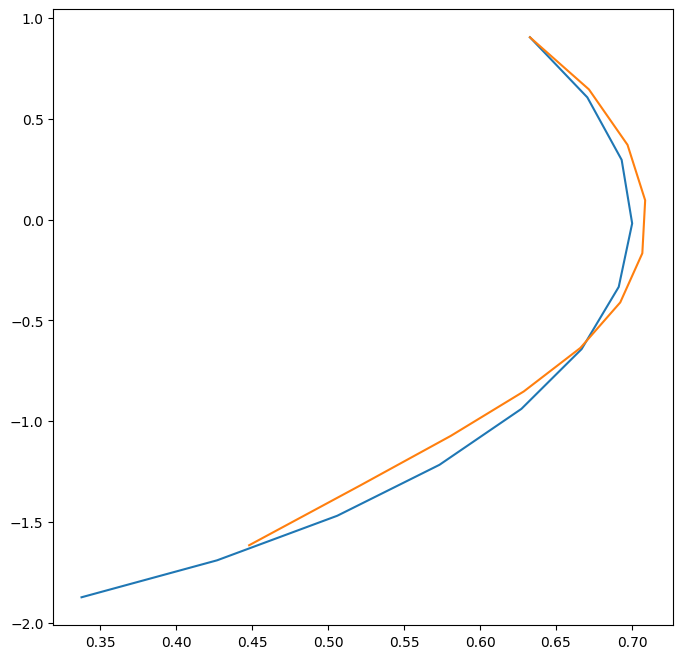

In [614]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(xhist[:, 0], xhist[:, 1], label='True trajectory')
ax.plot(zhist_pred[:, 0], zhist_pred[:, 1], label='Predicted trajectory')